<a href="https://colab.research.google.com/github/ruanvirginio/scriptsMestrado/blob/main/transformaBaseST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import plotly.express as px
import numpy as np
import os
import warnings

warnings.filterwarnings("ignore")

# Função para aplicar o filtro IQR
def filtrar_coluna_iqr(df, coluna):
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return df[(df[coluna] >= lower_bound) & (df[coluna] <= upper_bound)]

# Função para aplicar o filtro baseado em Média Móvel
def filtrar_coluna_media_movel(df, coluna, janela=20, threshold=4):

    media_movel = df[coluna].rolling(window=janela, center=True).mean()
    desvio = np.abs(df[coluna] - media_movel)

    # Determinando o limite de outliers baseado no desvio padrão local
    limite_superior = media_movel + threshold * desvio.std()
    limite_inferior = media_movel - threshold * desvio.std()

    return df[(df[coluna] >= limite_inferior) & (df[coluna] <= limite_superior)]

# Função para aplicar o filtro baseado em Z-Score
def filtrar_coluna_zscore(df, coluna, threshold=3):
    media = df[coluna].mean()
    desvio_padrao = df[coluna].std()
    z_scores = (df[coluna] - media) / desvio_padrao

    # Filtrando os valores cujo Z-Score seja menor que o threshold
    return df[np.abs(z_scores) < threshold]


# Função que aplica o filtro escolhido
def aplicar_filtro(df, coluna, metodo='iqr', janela=20, threshold=4, z_threshold=3):
    if metodo == 'iqr':
        return filtrar_coluna_iqr(df, coluna)
    elif metodo == 'media_movel':
        return filtrar_coluna_media_movel(df, coluna, janela=janela, threshold=threshold)
    elif metodo == 'zscore':
        return filtrar_coluna_zscore(df, coluna, threshold=z_threshold)
    else:
        raise ValueError("Método inválido! Escolha entre 'iqr', 'media_movel' ou 'zscore'.")


url = "https://media.githubusercontent.com/media/ruanvirginio/scriptsMestrado/refs/heads/main/demandaTrafos_2018-2023.csv"

df = pd.read_csv(url,  sep=';', encoding='latin-1')

# Renomeando as colunas
df.rename(columns={
    'Potencia Ativa': 'P',
    'Potencia Reativa': 'Q',
    'Data/Hora Medição': 'datahora'
}, inplace=True)

# Convertendo para datetime e salvando o módulo dos valores, pois pode ocorrer valores negativos
df['datahora'] = pd.to_datetime(df['datahora'], dayfirst=True, errors='coerce')
df['P'] = df['P'].abs()  # salvando o módulo dos valores
df['Q'] = df['Q'].abs()  # salvando o módulo dos valores
df['S'] = np.sqrt(df['P']**2 + df['Q']**2)  # Calculando a potência aparente (S), em kVA

# Removendo linhas com S = 0
df = df[df['S'] != 0]

# DataFrame final para armazenar os dados filtrados
df_filtrado = pd.DataFrame()

# Escolha do método de filtragem ('iqr', 'media_movel' ou 'zscore')
metodo_filtro = 'media_movel'

# Percorrendo cada transformador
for trafo in df['TRAFO'].unique():
    df_trafo = df[df['TRAFO'] == trafo]

    # Aplicando o filtro escolhido
    df_trafo_filtrado = aplicar_filtro(df_trafo, 'S', metodo=metodo_filtro, janela=20, threshold=4, z_threshold=3)

    # Adicionar os dados filtrados ao DataFrame final
    df_filtrado = pd.concat([df_filtrado, df_trafo_filtrado], ignore_index=True)

# Ordenando e removendo duplicatas
df_filtrado = df_filtrado.sort_values(by=['TRAFO', 'datahora'])
df_filtrado = df_filtrado.drop_duplicates(subset=['datahora', 'TRAFO'])

# Criando gráfico da Potência Aparente ao longo do tempo, separada por TRAFO
fig_aparente = px.line(df_filtrado, x='datahora', y='S', color='TRAFO',
                       title='Potência Aparente ao Longo do Tempo por Transformador',
                       labels={'S': 'Potência Aparente (kVA)', 'Dia': 'Data'})

# Exibir ou salvar o gráfico em
# fig_aparente.show()
# fig_aparente.write_html("Demanda ao longo do tempo - IQR.html")



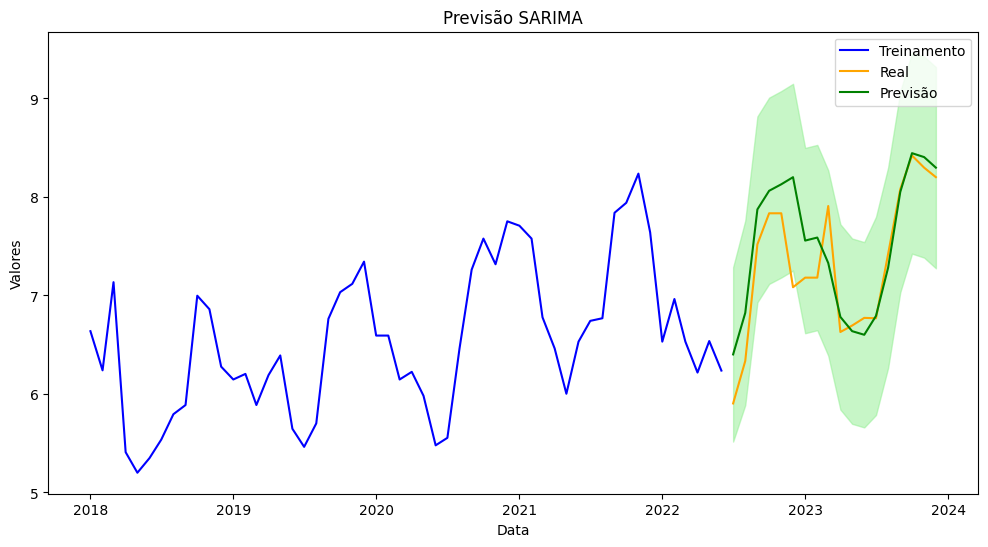

In [4]:
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

trafo_escolhido = 'PCO-02T1'

df = df_filtrado[df_filtrado['TRAFO'] == trafo_escolhido] # escolhendo algum transformador para predição

df = df[['datahora', 'S']]

df = df.set_index(['datahora'])

df = df.resample('MS').max()

df.sort_index(inplace=True)

df['S'] = df['S'].interpolate()

# Dividindo os dados em conjunto de treino e teste
train_size = int(len(df) * 0.75)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Ajustando o modelo SARIMA, com sazonalidade de 12 meses
model = SARIMAX(train['S'], order=(1, 1, 1), seasonal_order=(12, 1, 12, 12))
results = model.fit()

predictions = results.get_forecast(steps=len(test))
predicted_mean = predictions.predicted_mean
confidence_intervals = predictions.conf_int()

# Plot dos resultados
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['S'], label='Treinamento', color='blue')
plt.plot(test.index, test['S'], label='Real', color='orange')
plt.plot(predicted_mean.index, predicted_mean, label='Previsão', color='green')
plt.fill_between(predicted_mean.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='lightgreen', alpha=0.5)
plt.title('Previsão SARIMA')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.show()


## Preparação do conjunto de treino/teste

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

df = df_filtrado[df_filtrado['TRAFO'] == trafo_escolhido]

df = df[['datahora', 'S']]

df = df.set_index(['datahora'])

df = df.resample('D').max()

df.sort_index(inplace=True)

df['S'] = df['S'].interpolate()

dados = df[['S']].values

# Normalizando os dados:
scaler = MinMaxScaler(feature_range=(0, 1))
dados_normalizados = scaler.fit_transform(dados)

# Configurações da janela deslizante. 365 dias, para capturar a sazonalidade.
janela = 365
X, y = [], []
for i in range(janela, len(dados_normalizados)):
    X.append(dados_normalizados[i-janela:i, 0])
    y.append(dados_normalizados[i, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Dividindo em conjunto de treino e teste. 80/20.
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 292ms/step - loss: 0.0654
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 295ms/step - loss: 0.0072
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 23s 345ms/step - loss: 0.0065
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 413ms/step - loss: 0.0068
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 17s 338ms/step - loss: 0.0060
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 296ms/step - loss: 0.0063
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 332ms/step - loss: 0.0062
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 330ms/step - loss: 0.0071
Epoch 9/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 301ms/step - loss: 0.0068
Epoch 10/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 302ms/step - loss: 0.0066
Epoch 11/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 303ms/step - loss: 0.0058
Epoch 12/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 296ms/step - loss: 0.0057
Epoch 13/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 301ms/step - loss: 0.0061
Epoch 14/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 305ms/step - loss: 0.0068
Epoch 15/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 

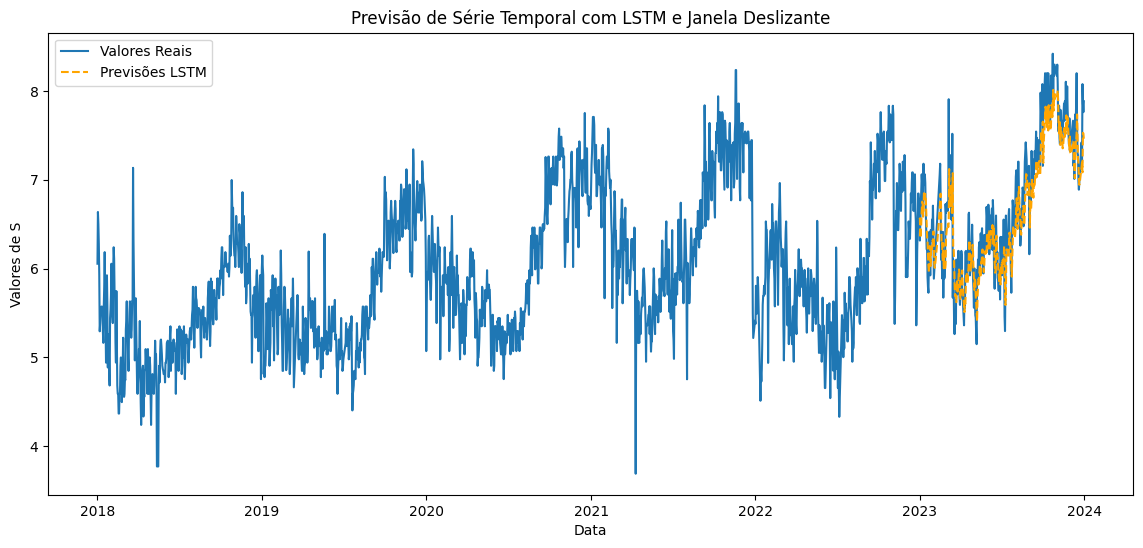

In [7]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Construindo o modelo LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32)

# Fazendo previsões no conjunto de teste
y_pred_normalizado = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred_normalizado)
print("Erro Quadrático Médio (MSE):", mse)

# Inversão da normalização, voltando aos valores reai
y_pred = scaler.inverse_transform(y_pred_normalizado)
y_test_inverso = scaler.inverse_transform(y_test.reshape(-1, 1))

# Ajustando o índice para os dados de previsão
df_previsoes = df.index[split + janela:]

# Visualizando os resultados
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['S'], label='Valores Reais')
plt.plot(df_previsoes, y_pred, label='Previsões LSTM', linestyle='--', color='orange')
plt.xlabel('Data')
plt.ylabel('Valores de S')
plt.title('Previsão de Série Temporal com LSTM e Janela Deslizante')
plt.legend()
plt.show()


Erro Quadrático Médio (MSE): 0.0059465682036271734


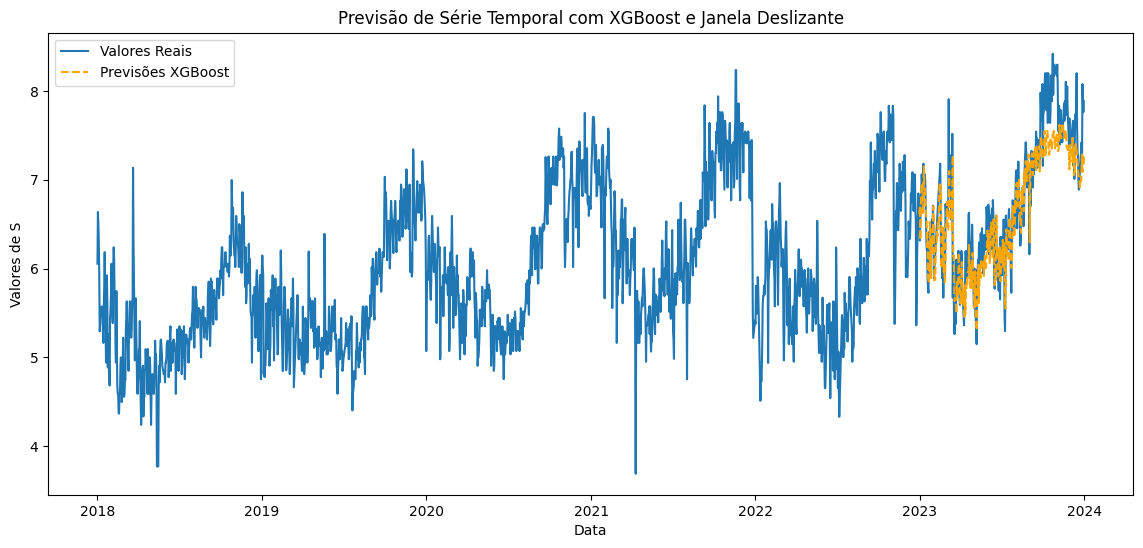

In [8]:
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Reshape necessário para XGBoost
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

# Construindo o modelo XGBoost
model = XGBRegressor(n_estimators=1000, learning_rate=0.01)
model.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste
y_pred_normalizado = model.predict(X_test)

# Calculando o Erro Quadrático Médio (MSE)
mse = mean_squared_error(y_test, y_pred_normalizado)
print("Erro Quadrático Médio (MSE):", mse)

# Inversão da normalização, voltando aos valores reais
y_pred = scaler.inverse_transform(y_pred_normalizado.reshape(-1, 1))
y_test_inverso = scaler.inverse_transform(y_test.reshape(-1, 1))

# Ajustando o índice para os dados de previsão
df_previsoes = df.index[split + janela:]

# Visualizando os resultados
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['S'], label='Valores Reais')
plt.plot(df_previsoes, y_pred, label='Previsões XGBoost', linestyle='--', color='orange')
plt.xlabel('Data')
plt.ylabel('Valores de S')
plt.title('Previsão de Série Temporal com XGBoost e Janela Deslizante')
plt.legend()
plt.show()
